#MIA Pipeline

#Understanding the project



##Data:

- .nii files are NIfTI (Neuroimaging Informatics Technology Initiative) files.
   A .nii file stores voxel-based volumetric image data (3D or 4D) together with metadata describing: Voxel dimensions (mm per pixel), Orientation (affine transformation from voxel → world coordinates), Data type (e.g., int16, float32), etc. We are given:


	•	T1native.nii.gz → subject’s T1 (input moving image)

	•	labels_native.nii.gz → subject’s corresponding label or segmented/GT (discrete)

	•	mni_icbm152_t1_tal_nlin_sym_09a.nii.gz → the atlas (fixed image)

	•	T1med.nii.gz → a precomputed median-filtered T1 (optional, for comparison)



##Pipeline

-Collect paths:

    -input: data_dir ('/content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data/subject01')

    -output: 2 required inputs for the pipeline (T1native, labels_native).


-Load subject images:

    -input: image_paths

    -output: image_dict[structure.BrainImageTypes.T1w] & image_dict[structure.BrainImageTypes.GroundTruth]



-Registeration:  T1 → atlas, and resample GT (NN): align multiple images (e.g., T1-weighted, T2-weighted MRI) into the same spatial coordinate system.

    -input: both t1 and gt, & atlas_img

    -output: registered_t1 & registered_gt


-Preprocess (Noise reduction, Bias field correction, Intensity normalization, Skull stripping / cropping and Resampling). It ensures consistent image quality and reduces confounding artifacts before feature extraction.

    -input: image_dict_reg

    -output: re-scaled t1

    -questions to consider:

        --Apply the brain mask to remove the skull from the T1w and T2w images (Do we need to apply the brain mask to the label image?)

        --Normalize the image intensities using z-score normalization (Do we need to normalize to GT image?)


-extract median feature: quantify meaningful image characteristics.

    -input:image_dict_reg

    -output: extracted features


    --image features:

          -edge/corner features

          -first order statistical texture features: the intensity distribution of an image without considering spatial relationships between pixels.
          They are computed directly from the histogram of gray values. For example, entropy is a first-order statistical feature because it depends only on the distribution of gray levels.

          -second order statistical texture features: gray-level co-occurrence matrix (GLCM) Corner Detection

          -other features:

              1. Hemisphere symmetry features (brain specific!)


              2. Deep-learning features

    --issues with feature selection:

          -Reduces the feature space by removing irrelevant/redundant/noisy features, i.e. a subset of features is used for classification

          -In the MIA pipeline, random forests are used as classification method

              --Selects the most relevant features

              --Provides feature importance

              --only have few features implemented




-classificaiton using RF (ensemble learning = bagging (Bootstrap Aggregating) + decision tree): Assign each pixel/voxel or region to a particular class.

    --information gain: Information Gain measures how much “uncertainty” (entropy) in the target variable is reduced after splitting the data based on a particular feature. It tells the model: “How informative is this feature for predicting the target?”

    --Random Forests are made up of many Decision Trees, and each tree uses Information Gain (or a related metric like Gini impurity) to decide where to split at each node.

    --For each candidate feature, t computes how much the split reduces entropy or impurity,The split with the highest Information Gain is chosen.

    --Each tree in the forest uses Information Gain (or Gini) to grow. The forest’s feature importance can be estimated by averaging the total information gain contributed by each feature across all trees.

        → Features with higher average IG are more informative overall.

    --Training is to Maximize Information Gain for training set.

    --Stopping Criteria
      
      --Number of Sample in a node is smaller than a threshold

      --A node is homogeneous (one class)


-post-processing: produces the final segmentation mask or diagnostic map for visualization and further analysis, with aims to improve the segmentation accuracy after the classification (currently no post-processing implemented
)


	•	Morphological filtering: remove small noisy regions or holes.
	•	Connected component analysis: keep only largest plausible structures.
	•	Smoothing or CRF refinement: enforce spatial consistency.
	•	Quantification: compute clinical measures — lesion volume, asymmetry index, etc.
  


-segmentation: the refined version of the segmentation — after applying spatial, morphological, or probabilistic corrections to improve quality and anatomical plausibility.



-evaluation: quantify the performance of the MIA pipeline by comparing automatic segmentation to ground truth (labels image), which is often manually segmented by experts.

    --choice of metric depends on segmentation task

    --recommend using multiple metics to show validy of results

    --Dice coef and Hausdorff distance widely used:

        ---Dice coef is senstive ti the scale of structure

        ---HD is sensitive to outliers, so often 95th quantile is used





In [1]:
!pip install SimpleITK
!pip install pymia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 3) Put your project root at the FRONT of sys.path
import sys, pathlib
project_root = '/content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb'
if project_root in sys.path:
    sys.path.remove(project_root)
sys.path.insert(0, project_root)

# 4) Ensure 'util' is a proper package in Drive
pathlib.Path(f'{project_root}/util/__init__.py').touch(exist_ok=True)

# 5) Clear any cached imports to avoid stale state
import sys as _sys
for mod in list(_sys.modules):
    if mod == 'util' or mod.startswith('util.'):
        del _sys.modules[mod]

In [4]:

# 4️⃣ Import your modules
from util import structure
from util import file_access_utilities as futil

print("✅ util modules imported successfully")

✅ util modules imported successfully


In [5]:
import os
import SimpleITK as sitk

import pymia.filtering.filter as fltr
import pymia.filtering.registration as fltr_reg

In [29]:
def collect_image_paths(data_dir):

    '''
    automatically find and organize all relevant image file paths (e.g., .nii.gz files) in a brain imaging dataset directory
    an automated tool that systematically searches a directory structure and collects paths to specific data files, following consistent naming and filtering rules.
    '''

    #defines the modalities or data types you want to retrieve for each subject
    #structure.BrainImageTypes helps standardize naming conventions across your code.
    image_keys = [structure.BrainImageTypes.T1w,
                  structure.BrainImageTypes.GroundTruth]

    #A custom subclass of futil.FilePathGenerator constructs the expected filename for each image type.
    class MyFilePathGenerator(futil.FilePathGenerator):
        @staticmethod
        def get_full_file_path(id_: str, root_dir: str, file_key, file_extension: str) -> str: #tells the crawler how to build the full path to a file given
            if file_key == structure.BrainImageTypes.T1w:
                file_name = 'T1native'
            elif file_key == structure.BrainImageTypes.GroundTruth:
                file_name = 'labels_native'
            else:
                raise ValueError('Unknown key')
            return os.path.join(root_dir, file_name +  file_extension)


    dir_filter = futil.DataDirectoryFilter() #decides which subdirectories the crawler should consider as valid data folders

    # create an instance of futil.FileSystemDataCrawler and pass the correpsonding arguments
    crawler = futil.FileSystemDataCrawler(
        root_dir=data_dir,
        file_keys=image_keys,
        file_path_generator=MyFilePathGenerator(),
        dir_filter=dir_filter,
        file_extension='.nii.gz')

    return crawler


def load_images(image_paths):

    # read the images (T1 as sitk.sitkFloat32, GroundTruth as sitk.sitkUInt8)
    image_dict = {
        structure.BrainImageTypes.T1w: sitk.ReadImage(image_paths[structure.BrainImageTypes.T1w], outputPixelType=sitk.sitkFloat32),
        structure.BrainImageTypes.GroundTruth: sitk.ReadImage(image_paths[structure.BrainImageTypes.GroundTruth], outputPixelType=sitk.sitkUInt8)
    }

    return image_dict


def register_images(image_dict, atlas_img):

    registration = fltr_reg.MultiModalRegistration() #creates an instance of the registration algorithm class to performs multi-modal intensity-based registration (often mutual information–driven rigid or affine registration)

    registration_params = fltr_reg.MultiModalRegistrationParams(atlas_img) #creates a parameter object that stores all the settings required for registration, as the registration parameters depend on the reference image’s geometry.


    # execute the registration with the T1-weighted image and the registration parameters

    registered_t1 = registration.execute(image_dict[structure.BrainImageTypes.T1w], registration_params)

    # apply transform to GroundTruth image (gt_img)

    gt_img = image_dict[structure.BrainImageTypes.GroundTruth]


    # resample ground-truth (label) images with nearest-neighbor (NN) interpolation.
    # labels are categorical. NN preserves integer class IDs and boundaries. Linear/cubic would create invalid fractional labels.

    registered_gt = sitk.Resample(
        gt_img,
        atlas_img,
        registration.transform, # transform estimated from T1 registration
        sitk.sitkNearestNeighbor,
        0, sitk.sitkUInt8)

    return registered_t1, registered_gt


def preprocess_filter_rescale_t1(image_dict, new_min_val, new_max_val):
    class MinMaxRescaleFilterParams(fltr.FilterParams):
        def __init__(self, min_, max_) -> None:
            super().__init__()
            self.min = min_
            self.max = max_

    class MinMaxRescaleFilter(fltr.Filter):
        def execute(self, img: sitk.Image, params: MinMaxRescaleFilterParams = None) -> sitk.Image:
            resacaled_img = sitk.RescaleIntensity(img, params.min, params.max)
            return resacaled_img

    # use the above filter and parameters to get the rescaled T1-weighted image
    rescaler = MinMaxRescaleFilter() # instantiate filter (no args)
    params = MinMaxRescaleFilterParams(new_min_val,new_max_val)
    minmax_rescaled_img = rescaler.execute(image_dict[structure.BrainImageTypes.T1w], params) # call .execute(img, params)

    return minmax_rescaled_img


def extract_feature_median_t1(image_dict):

  '''
  This applies a median filter to the T1-weighted image. Each voxel’s new value becomes the median of its neighbors’ intensities in a small window (usually 3×3×3).
  Purposes: reduces salt-and-pepper noise or isolated bright/dark voxels, and preserves edges better than Gaussian or mean filters.
  '''

  class MedianFilter(fltr.Filter):
        def execute(self, img: sitk.Image, params: fltr.FilterParams = None) -> sitk.Image:
            med_img = sitk.Median(img)
            return med_img

    # use the above filter class to get the median image feature of the T1-weighted image
  filter = MedianFilter()
  median_img = filter.execute(image_dict[structure.BrainImageTypes.T1w])

  return median_img #output a denoised version of the T1 image

In [30]:
# 0) Config — use the PARENT data folder here
DATA_DIR = '/content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data'

# 1) Build crawler with your function
crawler = collect_image_paths(DATA_DIR)
print(crawler.data.values())
# 2) Get one subject’s paths from the crawler’s dict
image_paths = next(iter(crawler.data.values()), None)
assert image_paths is not None, "No subjects found. Check DATA_DIR and file names."

# 3) Inspect what was found
for k, v in image_paths.items():
    print("  ", k, "->", v)

# 4) Use in your pipeline
image_dict = load_images(image_paths)

print(image_dict)
t1 = image_dict[structure.BrainImageTypes.T1w]
gt = image_dict[structure.BrainImageTypes.GroundTruth]

#print(t1)
#print(gt)


dict_values([{'subject01': '/content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data/subject01', <BrainImageTypes.T1w: 1>: '/content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data/subject01/T1native.nii.gz', <BrainImageTypes.GroundTruth: 3>: '/content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data/subject01/labels_native.nii.gz'}])
   subject01 -> /content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data/subject01
   BrainImageTypes.T1w -> /content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data/subject01/T1native.nii.gz
   BrainImageTypes.GroundTruth -> /content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data/subject01/labels_native.nii.gz
{<BrainImageTypes.T1w: 1>: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7dbc197ea790> >, <BrainImageTypes.GroundTruth: 3>: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7dbc1a8cc840> >}


In [31]:
# --- Load subject (unchanged) ---
#image_dict = load_images(image_paths)

# --- Load ICBM152 atlas as fixed image (update this path to your file) ---
atlas_path = os.path.join(DATA_DIR, 'mni_icbm152_t1_tal_nlin_sym_09a.nii.gz')
atlas_img  = sitk.ReadImage(atlas_path, outputPixelType=sitk.sitkFloat32)

In [32]:
# --- Register subject T1 -> atlas, and resample GT with NN---

registered_t1, registered_gt = register_images(image_dict, atlas_img)


In [33]:

# --- (Optional) quick sanity prints ---
print("Atlas size:", atlas_img.GetSize())
print("Registered T1 size:", registered_t1.GetSize())
print("Registered GT size:", registered_gt.GetSize())

Atlas size: (197, 233, 189)
Registered T1 size: (197, 233, 189)
Registered GT size: (197, 233, 189)


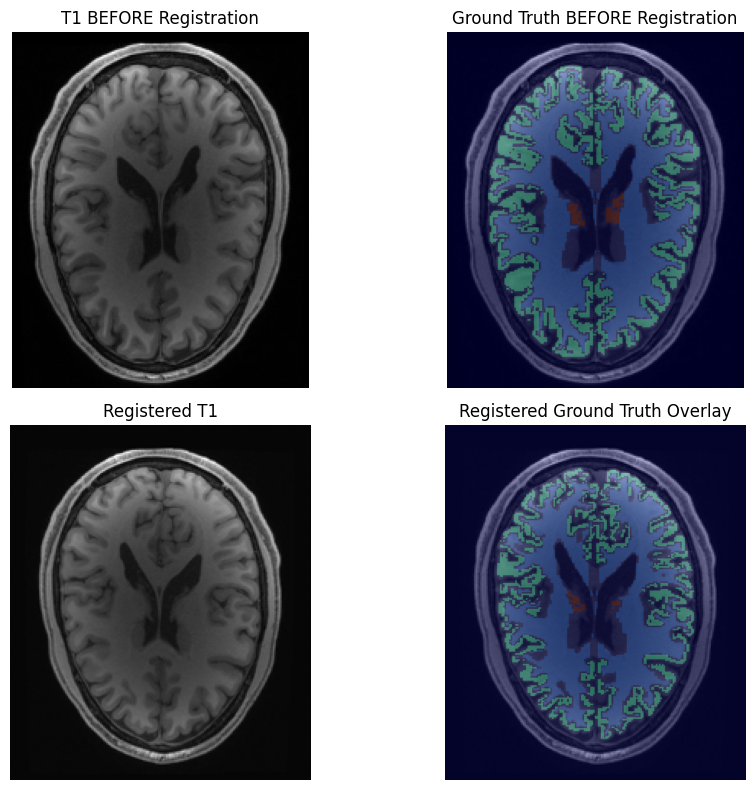

In [34]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# --- Load images ---
# Fixed atlas image (reference space)
atlas_img = sitk.ReadImage("/content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data/mni_icbm152_t1_tal_nlin_sym_09a.nii.gz")

# Moving images (before registration)
t1_before = image_dict[structure.BrainImageTypes.T1w]
gt_before = image_dict[structure.BrainImageTypes.GroundTruth]


# --- Convert to NumPy arrays for plotting ---
def sitk_to_np(img):
    return sitk.GetArrayFromImage(img)

t1_bef_np = sitk_to_np(t1_before)
gt_bef_np = sitk_to_np(gt_before)
t1_aft_np = sitk_to_np(registered_t1)
gt_aft_np = sitk_to_np(registered_gt)

# --- Choose middle slice (axial view) ---
z_bef = t1_bef_np.shape[0] // 2
z_aft = t1_aft_np.shape[0] // 2

# --- Plot all four ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# BEFORE registration
axes[0, 0].imshow(t1_bef_np[z_bef], cmap='gray')
axes[0, 0].set_title("T1 BEFORE Registration")
axes[0, 0].axis('off')

axes[0, 1].imshow(t1_bef_np[z_bef], cmap='gray')
axes[0, 1].imshow(gt_bef_np[z_bef], cmap='jet', alpha=0.3)
axes[0, 1].set_title("Ground Truth BEFORE Registration")
axes[0, 1].axis('off')

# AFTER registration
axes[1, 0].imshow(t1_aft_np[z_aft], cmap='gray')
axes[1, 0].set_title("Registered T1")
axes[1, 0].axis('off')

axes[1, 1].imshow(t1_aft_np[z_aft], cmap='gray')
axes[1, 1].imshow(gt_aft_np[z_aft], cmap='jet', alpha=0.3)
axes[1, 1].set_title("Registered Ground Truth Overlay")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [35]:
# --- Build an image_dict in atlas space so downstream funcs work without changing their signatures ---
image_dict_reg = {
    structure.BrainImageTypes.T1w: registered_t1,
    structure.BrainImageTypes.GroundTruth: registered_gt
}

# --- Preprocess on the *registered* T1 ---
# keep the dictionary-based API
median_t1 = extract_feature_median_t1(image_dict_reg)

# put the median image back under the same T1w key, then rescale
image_dict_reg_med = dict(image_dict_reg)
image_dict_reg_med[structure.BrainImageTypes.T1w] = median_t1

rescaled_t1 = preprocess_filter_rescale_t1(image_dict_reg_med, 0, 255)

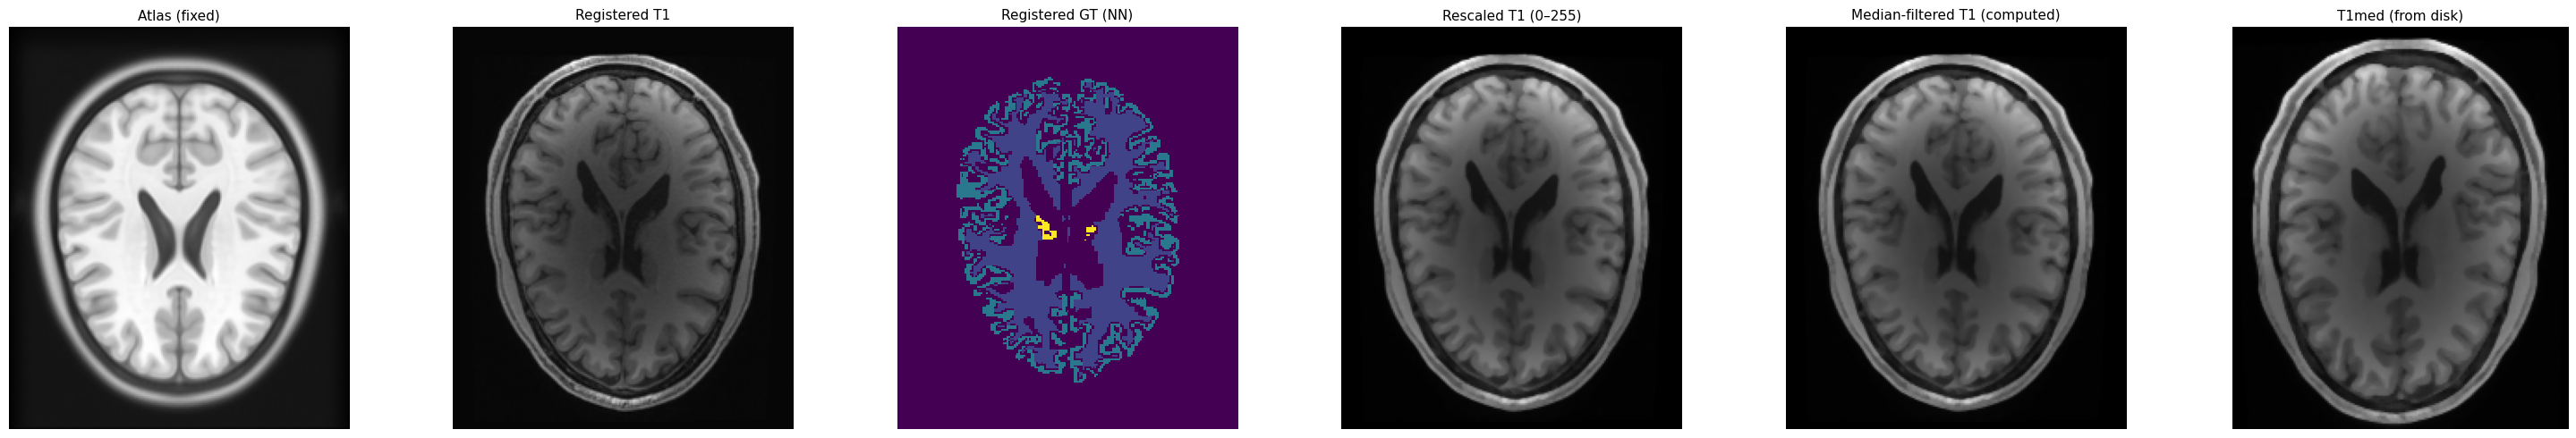

In [37]:
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np

# --- Load the T1med image from disk ---
t1med_path = '/content/drive/MyDrive/AI_in_Medicine_Semester3/MIA-LAb/data/T1med.nii.gz'
assert os.path.exists(t1med_path), f"T1med not found at {t1med_path}"
t1med_disk = sitk.ReadImage(t1med_path, outputPixelType=sitk.sitkFloat32)

# --- Function to show all images in one row ---
def show_row(images, titles, is_label_flags=None):
    n = len(images)
    if is_label_flags is None:
        is_label_flags = [False] * n

    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axes = [axes]

    for i, (img, title, is_label) in enumerate(zip(images, titles, is_label_flags)):
        arr = sitk.GetArrayFromImage(img)
        z = arr.shape[0] // 2  # middle slice
        axes[i].imshow(arr[z], cmap=None if is_label else 'gray',
                       interpolation='nearest' if is_label else None)
        axes[i].set_title(title, fontsize=11)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# --- Combine all your images ---
images = [
    atlas_img,        # fixed atlas
    registered_t1,    # subject registered to atlas
    registered_gt,    # label map after registration
    rescaled_t1,      # intensity rescaled version
    median_t1,        # median filter (computed)
    t1med_disk        # median filter (from disk)
    ]

titles = [
    "Atlas (fixed)",
    "Registered T1",
    "Registered GT (NN)",
    "Rescaled T1 (0–255)",
    "Median-filtered T1 (computed)",
    "T1med (from disk)"
]

# Boolean flag for label-type images (to keep crisp edges)
is_label_flags = [False, False, True, False, False, False]

# --- Show all in one line ---
show_row(images, titles, is_label_flags)

In [48]:
!pip install --upgrade pip
!pip install git+https://github.com/Radiomics/pyradiomics.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Cloning https://github.com/Radiomics/pyradiomics.git to /tmp/pip-req-build-_b0aa6hh
  Running command git clone --filter=blob:none --quiet https://github.com/Radiomics/pyradiomics.git /tmp/pip-req-build-_b0aa6hh
  Resolved https://github.com/Radiomics/pyradiomics.git to commit 8ed579383b44806651c463d5e691f3b2b57522ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 18.2 MB/s  0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.1.1.dev111+g

In [49]:
import radiomics
print("PyRadiomics version:", radiomics.__version__)

PyRadiomics version: 3.1.1.dev111+g8ed579383


#Feature extraction

In [50]:
# pip install pyradiomics
from radiomics import featureextractor

def extract_firstorder_features(image: sitk.Image,
                                mask: sitk.Image,
                                labels=None,
                                use_bin_count=True,
                                bin_count=64,
                                bin_width=25.0):
    """
    Extract First-Order radiomics features with PyRadiomics (extracts first-order features from the registered T1 image, using the ground truth (mask) to tell PyRadiomics where to extract them.)
    - image: SimpleITK image (float recommended, already registered/preprocessed)
    - mask:  SimpleITK label image (uint8/uint16), aligned with image
    - labels: list of label values to extract (default: all non-zero labels)
    - use_bin_count: if True, use fixed number of bins; else use fixed bin width
    - bin_count: number of gray-level bins (good when image is scaled to [0,1])
    - bin_width: alternative to bin_count (for raw intensity ranges)

    """
    # --- Type safety / casting ---
    # Keep image float (avoid uint8 quantization); make mask integer
    if image.GetPixelID() != sitk.sitkFloat32:
        image = sitk.Cast(image, sitk.sitkFloat32)
    if mask.GetPixelID() not in (sitk.sitkUInt8, sitk.sitkInt16, sitk.sitkUInt16):
        mask = sitk.Cast(mask, sitk.sitkUInt8)

    # --- Collect labels if not provided (exclude 0) ---
    if labels is None:
        arr = sitk.GetArrayFromImage(mask)
        labels = sorted([int(v) for v in np.unique(arr) if v != 0])
        if not labels:
            raise ValueError("Mask has no non-zero labels.")

    # --- Configure PyRadiomics extractor ---
    params = {
        "imageType": {"Original": {}},
        "featureClass": {"firstorder": []},  # empty list = enable all first-order features
        # Discretization:
        # If your image is [0,1] float, use a fixed number of bins.
        "setting": {
            "normalize": False,             # already normalized upstream
            "preCrop": True,                # speed: crop to mask bounding box
            "interpolator": "sitkBSpline",  # used only if internal resampling happens
            "resegmentRange": None,         # e.g., [0, 1] if you want to clamp
            "force2D": False
        }
    }
    if use_bin_count:
        params["setting"]["binCount"] = int(bin_count)    # good for [0,1] inputs
        params["setting"].pop("binWidth", None)
    else:
        params["setting"]["binWidth"] = float(bin_width)  # use this for native intensity ranges
        params["setting"].pop("binCount", None)

    extractor = featureextractor.RadiomicsFeatureExtractor(**params)
    # (Optional) sanity print:
    # print(extractor.enabledFeatures)

    # --- Run extraction for each label ---
    results = {}
    for lbl in labels:
        out = extractor.execute(image, mask, label=lbl)
        # Keep only first-order keys; PyRadiomics returns many housekeeping entries
        fo = {k: v for k, v in out.items() if "firstorder" in k.lower()}
        results[lbl] = fo
    return results

# ===== Example usage =====
# rescaled_t1  -> your median->rescaled T1 (float, ideally [0,1])
# registered_gt -> your NN-resampled label image
features_by_label = extract_firstorder_features(
    image=rescaled_t1,
    mask=registered_gt,
    labels=None,        # auto-detect all non-zero labels
    use_bin_count=True, # because image is [0,1]
    bin_count=64        # common choice; try 32/64/128 for sensitivity analysis
)

# Pretty-print one label’s features
for lbl, feats in features_by_label.items():
    print(f"\n=== First-order features for label {lbl} ===")
    for k in sorted(feats):
        print(f"{k}: {feats[k]}")

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'imageType': {'Original': {}}, 'featureClass': {'firstorder': []}, 'setting': {'normalize': False, 'preCrop': True, 'interpolator': 'sitkBSpline', 'resegmentRange': None, 'force2D': False, 'binCount': 64}}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loa


=== First-order features for label 1 ===
original_firstorder_10Percentile: 56.48303756713867
original_firstorder_90Percentile: 108.83482360839844
original_firstorder_Energy: 2841230582.2711053
original_firstorder_Entropy: 1.7998762082387834
original_firstorder_InterquartileRange: 25.751487731933594
original_firstorder_Kurtosis: 4.3930375863756685
original_firstorder_Maximum: 188.19345092773438
original_firstorder_Mean: 80.15440896007486
original_firstorder_MeanAbsoluteDeviation: 16.272122064599916
original_firstorder_Median: 76.89983367919922
original_firstorder_Minimum: 17.23195457458496
original_firstorder_Range: 170.9614963531494
original_firstorder_RobustMeanAbsoluteDeviation: 10.794554326558558
original_firstorder_RootMeanSquared: 82.90939109169138
original_firstorder_Skewness: 0.9971631165866753
original_firstorder_TotalEnergy: 2841230582.2711053
original_firstorder_Uniformity: 0.34452048447300576
original_firstorder_Variance: 449.23785545610536

=== First-order features for lab

In [40]:
import SimpleITK as sitk
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [41]:
# 1️⃣ Convert feature images and GT to numpy arrays
rescaled_arr = sitk.GetArrayFromImage(rescaled_t1).flatten()
median_arr   = sitk.GetArrayFromImage(median_t1).flatten()
gt_arr       = sitk.GetArrayFromImage(registered_gt).flatten()

# 2️⃣ Combine features into matrix X (num_voxels × num_features)
X = np.vstack([rescaled_arr, median_arr]).T
y = gt_arr
print(len(y))
print("Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)

# 3️⃣ Optionally mask out background voxels (label = 0)
mask = y > 0
X = X[mask]
y = y[mask]
print("After masking background:", X.shape, y.shape)


8675289
Feature matrix shape: (8675289, 2)
Label vector shape: (8675289,)
After masking background: (916090, 2) (916090,)


In [42]:
# 4️⃣ Standardize and apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)  # you have only 2 features; this decorrelates them
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [1.0000000e+00 5.9604616e-08]


In [56]:
import pandas as pd

def df_from_single_subject(features_by_label, subject_id="subj01"):
    rows = []
    for lbl, feats in features_by_label.items():
        if int(lbl) == 0:  # ignore background if present
            continue
        row = {"subject_id": subject_id, "roi_label": int(lbl)}
        row.update(feats)  # feature dict from PyRadiomics
        rows.append(row)
    if not rows:
        raise ValueError("No ROI rows found (non-zero labels).")
    return pd.DataFrame(rows)

# If your label id IS the class:
def build_Xy_single(df, label_to_class=None):
    # Optional: map label -> class name; else use label ID directly
    if label_to_class:
        df["target"] = df["roi_label"].map(label_to_class)
    else:
        df["target"] = df["roi_label"]  # integers as classes

    drop_cols = ["subject_id", "roi_label", "target"]
    X = df.drop(columns=[c for c in drop_cols if c in df.columns])
    y = df["target"]
    return X, y, df

df = df_from_single_subject(features_by_label, subject_id="subj01")
df

,subject_id,roi_label,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance
0,subj01,1,56.48303756713867,108.83482360839844,2841230582.2711053,1.7998762082387834,25.751487731933594,4.3930375863756685,188.19345092773438,16.272122064599916,80.15440896007486,76.89983367919922,17.23195457458496,170.9614963531494,10.794554326558558,82.90939109169138,0.9971631165866753,2841230582.2711053,0.34452048447300576,449.23785545610536
1,subj01,2,44.58016700744629,98.94987487792969,2518258706.6580873,1.864251350424384,28.116589546203613,3.76806620977286,177.3931884765625,17.02629446996986,69.32648841053172,66.26951599121094,11.783658027648926,165.60953044891357,11.736393748916825,72.61801695942997,0.8227503184154598,2518258706.6580873,0.32310534275592984,467.2143917844679
2,subj01,3,34.96131896972656,45.71509971618652,12061848.33181369,0.09401076730772424,6.5941667556762695,2.786808284350109,57.850704193115234,3.5574493531284124,40.105098912681825,39.81131935119629,24.716697692871094,33.13400650024414,2.6425112376707975,40.3348680720109,0.2874660290569507,12061848.33181369,0.9765397291150558,18.48262359053113
3,subj01,4,34.070203399658205,41.08864364624023,3505714.5604477506,0.005065109689645675,3.7298221588134766,3.771842188257892,49.29486083984375,2.2560034925429764,37.223789786154896,36.82349395751953,24.951242446899414,24.343618392944336,1.5481185640424366,37.33526872056074,0.4449451719284799,3505714.5604477506,0.999205087566055,8.311764392631728
4,subj01,5,42.728919982910156,52.25701141357422,34995440.33954603,0.8560419761822348,5.108942031860352,3.543577122337544,59.61520767211914,3.0057390528983428,47.69636391872841,48.1023063659668,27.063264846801758,32.55194282531738,2.1059827641103994,47.84588570265118,-0.41821332695112867,34995440.33954603,0.596418144060151,14.285647603383168


In [57]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# --- 1) Build X, y from your df ---
# df columns: ['subject_id','roi_label', <lots of original_firstorder_* columns>]
df = df.copy()
df["target"] = df["roi_label"]          # use ROI label as class for now
drop_cols = ["subject_id", "roi_label", "target"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["target"].astype(int)

print("X shape:", X.shape)
print("Classes:", np.unique(y))

# --- 2) Pipeline: impute -> RandomForest ---
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ))
])

# --- 3) Fit & evaluate on training data (only 5 samples, so this is just a sanity check) ---
pipe.fit(X, y)
y_pred = pipe.predict(X)

print("\n=== Training metrics (same-data) ===")
print(classification_report(y, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y, y_pred))

# --- 4) Top feature importances ---
rf = pipe.named_steps["rf"]
imps = rf.feature_importances_
order = np.argsort(imps)[::-1][:10]
print("\nTop 10 features:")
for i in order:
    print(f"{X.columns[i]}: {imps[i]:.4f}")

# --- 5) (Optional) save model & feature list ---
#joblib.dump(pipe, "rf_firstorder_single_subject.joblib")
#pd.Series(X.columns).to_csv("rf_feature_columns.csv", index=False)
#print("\nSaved model to rf_firstorder_single_subject.joblib and columns to rf_feature_columns.csv")

X shape: (5, 18)
Classes: [1 2 3 4 5]

=== Training metrics (same-data) ===
              precision    recall  f1-score   support

           1      1.000     1.000     1.000         1
           2      1.000     1.000     1.000         1
           3      1.000     1.000     1.000         1
           4      1.000     1.000     1.000         1
           5      1.000     1.000     1.000         1

    accuracy                          1.000         5
   macro avg      1.000     1.000     1.000         5
weighted avg      1.000     1.000     1.000         5

Confusion matrix:
 [[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

Top 10 features:
original_firstorder_10Percentile: 0.0803
original_firstorder_Minimum: 0.0677
original_firstorder_MeanAbsoluteDeviation: 0.0649
original_firstorder_TotalEnergy: 0.0628
original_firstorder_InterquartileRange: 0.0619
original_firstorder_90Percentile: 0.0605
original_firstorder_Variance: 0.0575
original_firstorder_Kurtosis: 0.0557
ori

Loaded data from: User arrays  |  X shape: (100000, 2)  y shape: (100000,)
After subsample: X (100000, 2), y (100000,)
Decision forest training...
Decision forest testing...
Feature importance: [0.84179371 0.15820629]
Training accuracy: 61.71%
Testing accuracy:  58.82%
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetric

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# ---------- A) Build a tidy DataFrame from multiple subjects ----------
def df_from_multiple_subjects(all_subjects_results,
                              global_label_to_class=None,
                              per_subject_label_to_class=None):
    """
    all_subjects_results: {"subj01": {label: {feat: val}, ...}, "subj02": {...}, ...}
    global_label_to_class: e.g., {1:"tumor", 2:"edema"}  (optional)
    per_subject_label_to_class: e.g., {"subj01": {1:"tumor",2:"edema"}, ...} (optional)
    """
    rows = []
    for sid, fbl in all_subjects_results.items():
        for lbl, feats in fbl.items():
            lbl = int(lbl)
            if lbl == 0:  # ignore background if present
                continue
            row = {"subject_id": sid, "roi_label": lbl}
            row.update(feats)

            # choose class label (string or int)
            if per_subject_label_to_class and sid in per_subject_label_to_class and lbl in per_subject_label_to_class[sid]:
                row["target"] = per_subject_label_to_class[sid][lbl]
            elif global_label_to_class and lbl in global_label_to_class:
                row["target"] = global_label_to_class[lbl]
            else:
                row["target"] = lbl   # fallback: use ROI label as class
            rows.append(row)

    if not rows:
        raise ValueError("No ROI rows found. Check inputs / labels.")
    df = pd.DataFrame(rows)

    # Align columns (some subjects may miss features)
    df = df.sort_index(axis=1)
    return df

# ---------- B) Prepare X, y, groups ----------
def build_Xy_groups(df):
    drop_cols = ["subject_id", "roi_label", "target"]
    X = df.drop(columns=[c for c in drop_cols if c in df.columns])
    y = df["target"]
    groups = df["subject_id"]
    return X, y, groups

# ---------- C) Choose safe number of folds (need enough subjects per class) ----------
def safe_group_folds(y, groups, max_folds=5):
    # count unique subjects per class
    subjects_per_class = (
        pd.DataFrame({"y": y, "g": groups})
        .groupby("y")["g"].nunique()
    )
    min_subj = int(subjects_per_class.min())
    if min_subj >= max_folds:
        return max_folds
    elif min_subj >= 3:
        return 3
    elif min_subj >= 2:
        return 2
    else:
        return None

# ---------- D) End-to-end training & evaluation ----------
def train_eval_rf_multisubject(df, n_estimators=500, random_state=42, save=False):
    X, y, groups = build_Xy_groups(df)

    print("Samples:", len(df), "| Features:", X.shape[1])
    print("Subjects:", df['subject_id'].nunique())
    print("Class distribution:", Counter(y))

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=n_estimators,
            class_weight="balanced",
            random_state=random_state,
            n_jobs=-1
        ))
    ])

    n_splits = safe_group_folds(y, groups, max_folds=5)
    if n_splits is None:
        print("\n⚠️ Not enough subjects per class for GroupKFold. "
              "Fit on all data (metrics are optimistic).")
        pipe.fit(X, y)
        y_pred = pipe.predict(X)
        print("\n=== Training (same-data) report ===")
        print(classification_report(y, y_pred, digits=3))
        print("Confusion matrix:\n", confusion_matrix(y, y_pred))
    else:
        print(f"\nUsing GroupKFold with n_splits={n_splits} (subject-wise CV)")
        gkf = GroupKFold(n_splits=n_splits)

        # CV accuracy
        scores = cross_val_score(pipe, X, y, cv=gkf.split(X, y, groups),
                                 scoring="accuracy", n_jobs=-1)
        print(f"CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

        # CV predictions for confusion matrix / report
        y_pred_cv = cross_val_predict(pipe, X, y, cv=gkf.split(X, y, groups),
                                      n_jobs=-1)
        print("\n=== Cross-validated report (pooled folds) ===")
        print(classification_report(y, y_pred_cv, digits=3))
        print("Confusion matrix (CV pooled):\n", confusion_matrix(y, y_pred_cv))

        # Fit on full data once to inspect feature importances
        pipe.fit(X, y)

    # Top feature importances
    rf = pipe.named_steps["rf"]
    if hasattr(rf, "feature_importances_"):
        imps = rf.feature_importances_
        order = np.argsort(imps)[::-1][:15]
        print("\nTop 15 features:")
        for i in order:
            print(f"{X.columns[i]}: {imps[i]:.4f}")

    # Optional save
    if save:
        joblib.dump(pipe, "rf_firstorder_multisubject.joblib")
        pd.Series(X.columns).to_csv("rf_feature_columns.csv", index=False)
        print("\nSaved model → rf_firstorder_multisubject.joblib")
        print("Saved feature columns → rf_feature_columns.csv")

# ======================
# EXAMPLE USAGE:
# all_subjects_results = {
#   "subj01": features_by_label_s1,  # dict {label: {feat: val}}
#   "subj02": features_by_label_s2,
#   ...
# }
# global_label_to_class = {1:"tumor", 2:"edema", 3:"healthy", 4:"csf", 5:"other"}  # optional

# df = df_from_multiple_subjects(all_subjects_results, global_label_to_class=global_label_to_class)
# train_eval_rf_multisubject(df, n_estimators=600, save=True)
# ======================